# Predicting Next Purchase Day

### Importing required Libraries

In [1]:
from __future__ import division
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode()

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [2]:
tx_data = pd.read_csv('../datasets/OnlineRetail.csv', encoding="cp1252")

In [29]:
tx_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [30]:
tx_data.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID Country  
541904 2011-12-09 12:50:00       0.85     12680.0  France  
541905 2011-12-09 12:50:00       2.10     12680.0  France  
541906 2011-12-09 12:50:00       4.15     12680.0  France  
541907 2011-12-09 12:50:00       4.15     12680.0  France  
541908 2011-12-09 12:50:00       4.95     12680.0  France

In [31]:
tx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


###  Data Pre-Processing and Wrangling

In [6]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [7]:
#tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk = tx_data[tx_data["Country"] == "United Kingdom"]
print(tx_uk.shape)

(495478, 8)


In [8]:
tx_6m = tx_uk[(tx_uk.InvoiceDate < np.datetime64(date(2011,9,1))) & (tx_uk.InvoiceDate >= np.datetime64(date(2011,3,1)))].reset_index(drop=True)
tx_next = tx_uk[(tx_uk.InvoiceDate >= np.datetime64(date(2011,9,1))) & (tx_uk.InvoiceDate < np.datetime64(date(2011,12,1)))].reset_index(drop=True)
print(tx_6m.shape, tx_next.shape)

(195465, 8) (178694, 8)


In [9]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [10]:
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [11]:
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [12]:
#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

In [13]:
#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

In [14]:
#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [15]:
#print tx_user
tx_user.head()

CustomerID  NextPurchaseDay
0     14620.0              NaN
1     14740.0              NaN
2     13880.0             57.0
3     16462.0            111.0
4     17068.0             16.0

In [16]:
#fill NA values with 999
tx_user = tx_user.fillna(999)

### Feature Engineering

In [17]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()


#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

#plot frequency
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


#calculate monetary value, create a dataframe with it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

#plot Revenue
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

#plot revenue vs frequency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot revenue vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot frequency vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [18]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [19]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [20]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [21]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [22]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [23]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [24]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

<AxesSubplot:>

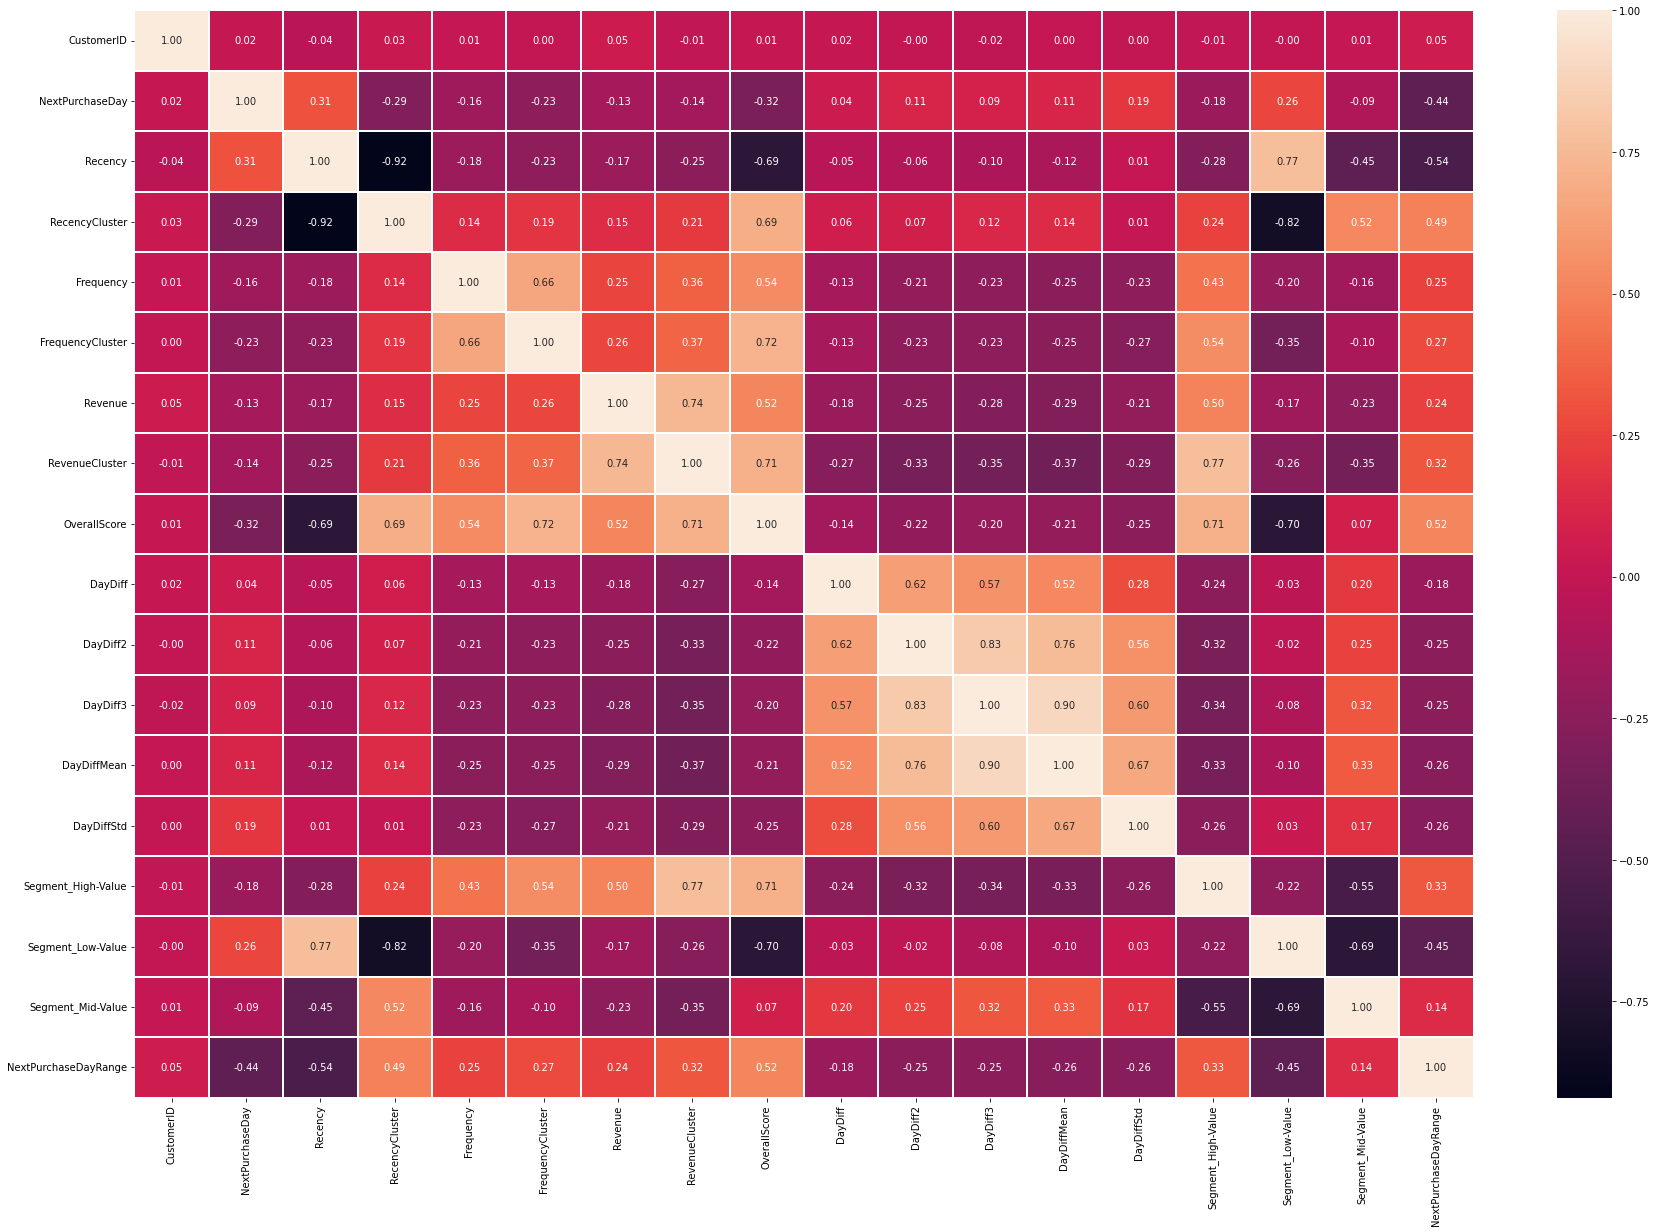

In [25]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [26]:
#train & test split
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

LR [0.59437751 0.59437751]
NB [0.59437751 0.69076305]
RF [0.56626506 0.68273092]
SVC [0.51004016 0.5060241 ]
Dtree [0.53815261 0.65060241]
XGB [0.58232932 0.62650602]
KNN [0.53012048 0.48995984]


In [27]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print("Training: "+str(xgb_model.score(X_train, y_train)))
print("Testing: "+str(xgb_model.score(X_test[X_train.columns], y_test)))

Training: 1.0
Testing: 0.608


In [28]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid = param_test1, scoring='accuracy',n_jobs=-1,refit=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.6024096385542168)